In [ ]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 8
nA = 2
seed = 3231
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, gamma=gamma, small=5, large=1000, seed=seed)
tau = 0.3
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)


In [ ]:
r_s_a = compute_r_s_a(tmdp.P_mat_tau, tmdp.reward)
r_s_a_xi = compute_r_s_a(tmdp.xi, tmdp.reward)
r_s_a_p = compute_r_s_a(tmdp.P_mat, tmdp.reward)

Q_star, _ = bellman_optimal_q(tmdp.P_mat_tau, tmdp.reward, gamma).values()
pi = get_policy(Q_star)
pi_prime = np.array([[0., 1.] for i in range(nS)])
d = compute_d(mu, tmdp.P_mat_tau, pi, tmdp.gamma)
V_star = get_value_function(Q_star)
print(tmdp.P_mat.shape)
print(Q_star)

Q_star_0 , _ = bellman_optimal_q(tmdp.P_mat, tmdp.reward, gamma).values()
print(Q_star_0)

(8, 2, 8)
[[197.33860226 192.95416508]
 [193.65110261 191.12121965]
 [191.32797784 189.99387525]
 [189.86440925 191.23860869]
 [189.8081067  198.77761403]
 [194.55768008 223.6183101 ]
 [210.20731862 302.85617042]
 [260.12717063 555.34815579]]
[[ 68.0544467   70.06049679]
 [ 63.05444711  96.0088304 ]
 [ 86.40794736 140.21710219]
 [126.19539197 206.88545394]
 [186.19690854 305.73248103]
 [275.15923293 451.91574319]
 [406.72416887 668.01969924]
 [601.21772931 987.46905542]]


In [12]:
print(r_s_a_p)
print(r_s_a_xi)
print(r_s_a)

             

[[  5.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0. 300.]]
[[  0.625   0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.    125.   ]]
[[  3.6875   0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.     247.5   ]]


In [10]:
status_step = 30000

q_p = get_q_hat( tmdp.P_mat, r_s_a_p, tmdp.gamma, Q_star)
q_xi = get_q_hat(tmdp.xi, r_s_a_xi, tmdp.gamma, Q_star)

print("Q_hat_P:\n", q_p)
print("Q_hat_xi:\n",q_xi)
print("Rebuilted Q:\n", (1-tmdp.tau) * q_p + tmdp.tau * q_xi)
print("Q:\n", Q_star)

Q_hat_P:
 [[182.60474204 176.60911713]
 [177.60474204 173.99062363]
 [174.28599234 172.38013161]
 [172.19518005 174.15832249]
 [172.11474782 184.92833009]
 [178.89985263 220.41503873]
 [201.25647909 333.611982  ]
 [272.57055338 640.74338943]]
Q_hat_xi:
 [[231.71761095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 356.09261095]]
Rebuilted Q:
 [[197.33860271 192.95416527]
 [193.65110271 191.12121982]
 [191.32797792 189.99387541]
 [189.86440932 191.23860902]
 [189.80810676 198.77761434]
 [194.55768012 223.6183104 ]
 [210.20731865 302.85617068]
 [260.12717065 555.34815588]]
Q:
 [[197.33860226 192.95416508]
 [193.65110261 191.12121965]
 [191.32797784 189.99387525]
 [189.86440925 191.23860869]
 [189.8081067  198.77761403]
 [194.55768008 223.6183101 ]
 [210.20731862 302.85617042]
 [260.12717063 555.34815579]]


In [5]:
Q = np.zeros((nS, nA))
Qs = Q_learning(tmdp, Q, alpha=0.04, episodes=1000000, status_step=status_step)

KeyboardInterrupt: 

In [ ]:
Q_0 = np.zeros((nS, nA))
Qs_0 = Q_learning(mdp, Q_0, alpha=0.1, episodes=1000000, status_step=status_step, state_distribution=d)

In [ ]:
print(Qs["Qs"][-1])
print(Qs_0["Qs"][-1])
visits = Qs["visits"]
print(visits)
visit_dist = visits / np.sum(visits)
print(visit_dist)
print(d)

[[194.8231034  175.39653653]
 [190.93777594 173.48194597]
 [187.20284641 171.786834  ]
 [170.13875807 188.73089059]
 [178.40688585 199.73030427]
 [189.48302311 226.12515669]
 [209.95213269 307.72035988]
 [256.18333662 569.57565288]]
[[  64.48125219   69.11695245]
 [  64.27903908   96.04956153]
 [  88.89253795  143.71683   ]
 [ 130.09476599  209.53755836]
 [ 195.5492488   311.74382759]
 [ 287.46281601  467.58347569]
 [ 419.74249853  685.69676736]
 [ 619.33495984 1005.92537928]]
[127455. 128540. 115529. 109747. 120417. 142649. 176829.  78842.]
[0.12745398 0.12853897 0.11552808 0.10974612 0.12041604 0.14264786
 0.17682759 0.07884137]
[0.2591634  0.07879438 0.05165775 0.08583725 0.11334557 0.12742383
 0.18389381 0.09988401]


In [ ]:
print(get_policy(Qs_0["Qs"][1]))

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
visit_weights = 1.0 / (d + 1e-8)
visit_weights = visit_weights / np.sum(visit_weights)
print(visit_weights)

[0.0484271  0.15928206 0.24295544 0.14621311 0.11072804 0.09849439
 0.0682488  0.12565106]


In [ ]:
print(d)
print(Qs["visit_weights"])
print(get_policy(Qs["Qs"][-1]))
print(pi)

[0.2591634  0.07879438 0.05165775 0.08583725 0.11334557 0.12742383
 0.18389381 0.09988401]
[0.11702142 0.11603365 0.12910148 0.13590317 0.12386096 0.1045571
 0.08434683 0.18917537]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
tau_prime = 0.
metrics = compute_metrics(tmdp, Qs["Qs"], Q_star, tau_prime=tau_prime)
metrics_0 = compute_metrics(mdp, Qs_0["Qs"], Q_star_0, tau_prime=tau_prime)
print(metrics)
print(metrics_0)

{'J': [35.595799375000006, 246.48188362430128, 259.88149425432823, 246.48188362430128, 362.54953332572023, 316.06060621667064, 316.06060621667064, 307.02578287933886, 340.6844168677573, 246.48188362430128, 340.6844168677573, 261.1985880066813, 293.05371165085023, 310.05861698072135, 334.09955429301215, 316.06060621667064, 322.2214666222897, 265.51698800021546, 246.48188362430128, 340.6844168677573, 355.03300635211065, 316.06060621667064, 322.2214666222897, 316.06060621667064, 307.02578287933886, 316.06060621667064, 340.6844168677573, 268.2465386914597, 316.06060621667064, 316.06060621667064, 316.06060621667064, 340.6844168677573, 340.6844168677573, 340.6844168677573, 340.6844168677573, 340.6844168677573], 'J_tau': [12.148623500089025, 239.70514708584065, 245.33353865179004, 239.70514708584065, 253.0961772742671, 256.0592008142275, 256.0592008142275, 251.2349231813987, 256.76957059431527, 239.7051470858408, 256.76957059431527, 247.58963708380466, 245.42824898977028, 253.56143173191762, 

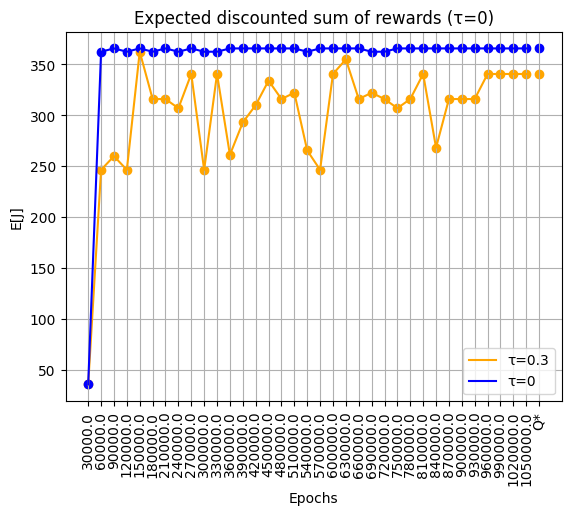

In [ ]:
x = np.array([])
y_0 = np.array([])
y = np.array([])

for i, J in enumerate(metrics["J"]):
    y = np.append(y, J)
    y_0 = np.append(y_0, metrics_0["J"][i])
    if i < len(metrics["J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.scatter(x, y_0, c="blue")

plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_0[:-1], c="blue", label="τ=0")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("E[J]")
plt.title("Expected discounted sum of rewards (τ=0)")
plt.grid(visible=True)


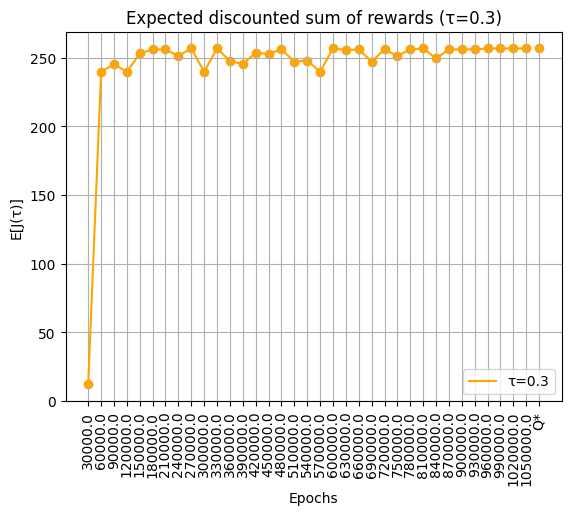

In [ ]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["J_tau"]):
    y = np.append(y, J)
    if i < len(metrics["J_tau"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.xticks(x_map, x)
plt.scatter(x, y, c="orange")

plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards (τ={})".format(tmdp.tau))
plt.grid(visible=True)

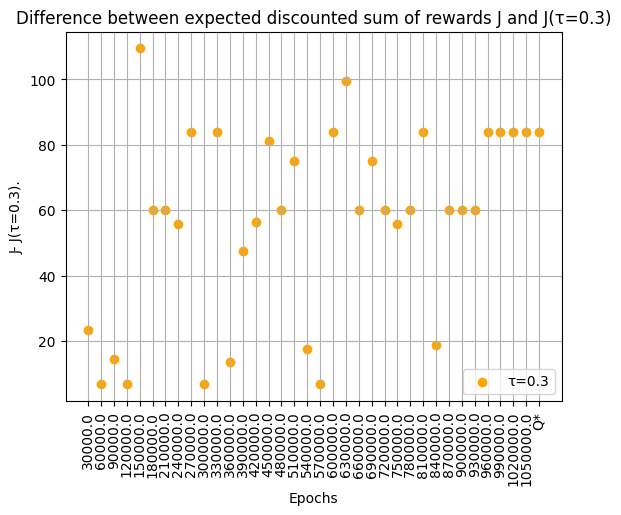

In [ ]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["delta_J"]):
    y = np.append(y, J)
    if i < len(metrics["delta_J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.xticks(x_map, x)
plt.scatter(x, y, c="orange", label="τ={}".format(tmdp.tau))
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.xticks(rotation=90)
plt.ylabel("J- J(τ={}).".format(tmdp.tau))
plt.title("Difference between expected discounted sum of rewards J and J(τ={})".format(tmdp.tau))
plt.grid(visible=True)

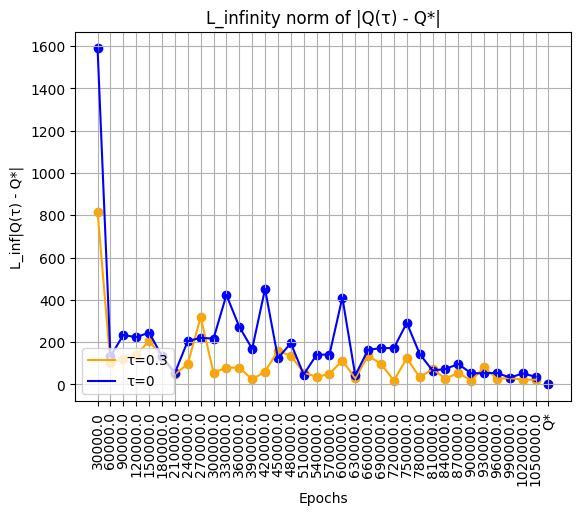

In [ ]:
x = np.array([])
y = np.array([])
y_0 = np.array([])
for i, J in enumerate(metrics["delta_Q"]):
    y = np.append(y, J)
    y_0 = np.append(y_0, metrics_0["delta_Q"][i])
    if i < len(metrics["delta_Q"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.scatter(x, y_0, c="blue")

plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_0[:-1], c="blue", label="τ=0")
plt.legend(loc="lower left")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("L_inf|Q(τ) - Q*|")
plt.title("L_infinity norm of |Q(τ) - Q*|")
plt.grid(visible=True)

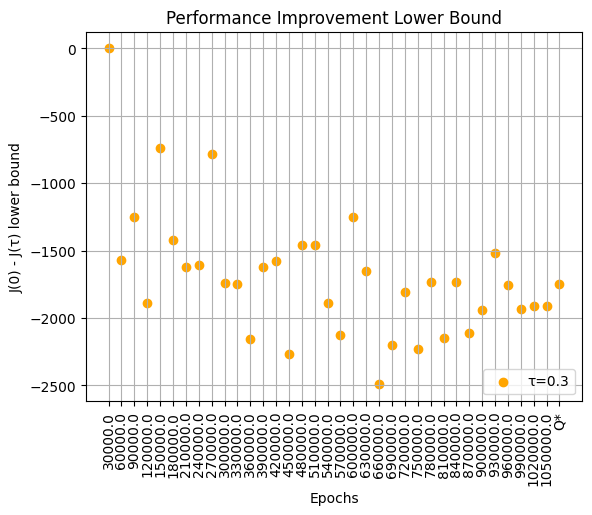

In [ ]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["l_bounds"]):
    y = np.append(y, J)
    if i < len(metrics["l_bounds"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange", label="τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("J(0) - J(τ) lower bound")
plt.title("Performance Improvement Lower Bound")
plt.grid(visible=True)

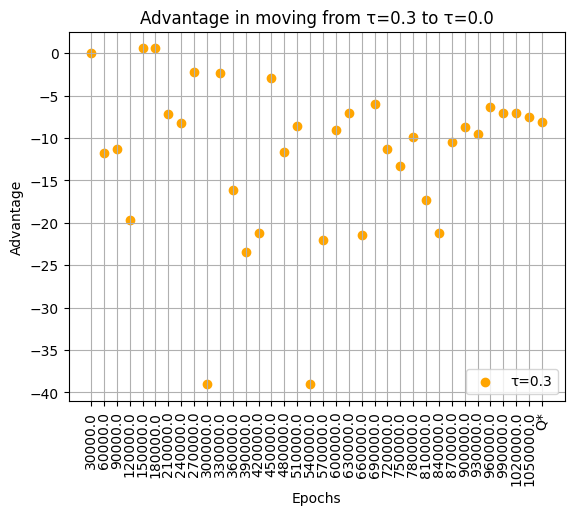

In [ ]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["adv_terms"]):
    y = np.append(y, J)
    if i < len(metrics["adv_terms"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange", label="τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("Advantage")
plt.title("Advantage in moving from τ={} to τ={}".format(tmdp.tau, tau_prime))
plt.grid(visible=True)

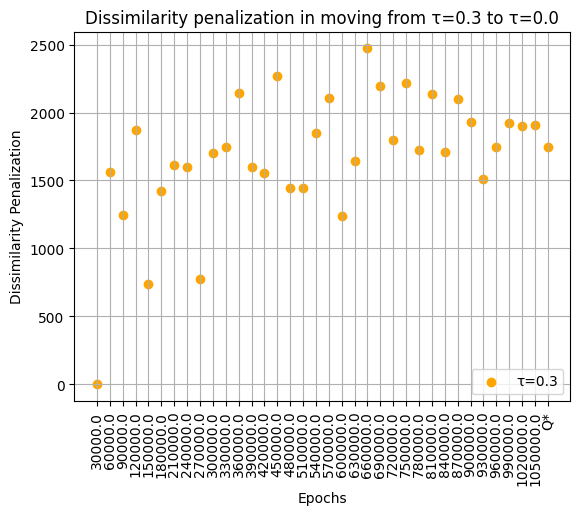

In [ ]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["diss_terms"]):
    y = np.append(y, J)
    if i < len(metrics["diss_terms"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange", label="τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("Dissimilarity Penalization")
plt.title("Dissimilarity penalization in moving from τ={} to τ={}".format(tmdp.tau, tau_prime))
plt.grid(visible=True)